In [ ]:
!pip install peft pydantic matplotlib transformers datasets evaluate accelerate bitsandbytes seaborn
!pip install -U bitsandbytes
!pip install neural-compressor optimum
# Optimum ONNX (includes CLI and export helpers) and ONNX Runtime
!pip install "optimum[onnxruntime]" onnxruntime-gpu onnx onnxconverter-common



  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [ ]:
!git clone https://github.com/jayb71/learning_model_quantization repo

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm



/home/jayy/nlp_asgn/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds = load_dataset("dair-ai/emotion", "split")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

encoded = ds.map(tokenize, batched=True)
encoded = encoded.remove_columns(["text"])
encoded = encoded.rename_column("label", "labels")
encoded.set_format("torch")


train_loader = DataLoader(encoded["train"], batch_size=8, shuffle=True)
test_loader = DataLoader(encoded["test"], batch_size=8)
val_loader = DataLoader(encoded["validation"], batch_size=8)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Baseline Training

In [5]:
# model_baseline = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=6)
# optimizer_baseline = AdamW(model_baseline.parameters(), lr=2e-5)

# model_baseline.to(device)
# for epoch in range(3):
#     model_baseline.train()
#     training_loss = 0
#     validation_loss = 0
#     for batch in tqdm(train_loader):
#         optimizer_baseline.zero_grad()
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)

#         outputs = model_baseline(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         training_loss += loss.item()
#         loss.backward()
#         optimizer_baseline.step()
    
#     model_baseline.eval()
#     for batch in tqdm(val_loader):
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)
#         with torch.no_grad():
#             outputs = model_baseline(input_ids, attention_mask=attention_mask, labels=labels)
#             val_loss = outputs.loss
#             validation_loss += val_loss.item()
#     print(f"epoch {epoch+1} completed . Validation Loss: {validation_loss/len(val_loader)} Train Loss: {training_loss/len(train_loader)}")

# model_baseline.save_pretrained("saved/baseline-model")

# Post Training Quantization

In [6]:
# model_ptq = torch.ao.quantization.quantize_dynamic(
#     model_baseline,
#     {torch.nn.Linear}, # only linear layers are quantized
#     dtype=torch.qint8 # quantization data type
# )

# torch.save(model_ptq.state_dict(), "saved/ptq_int8_model.pt")


# QAT

In [7]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
# from neural_compressor.training import prepare_compression
# from neural_compressor.config import QuantizationAwareTrainingConfig
# from datasets import load_dataset

# model_qat = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=6)

# # 2. Configure QAT
# qat_config = QuantizationAwareTrainingConfig(
# )

# # 3. Wrap model for QAT
# compression_controller = prepare_compression(model_qat, qat_config)
# qat_model = compression_controller.model  # now contains fake-quant modules

# qat_model.to(device)

# # 4. Finetune (REAL QAT happens here)
# args_qat = TrainingArguments(
#     output_dir="./qat_bert",
#     num_train_epochs=3,
#     learning_rate=3e-5,
#     per_device_train_batch_size=8,
#     remove_unused_columns=False,
# )

# # Use manual training loop instead of Trainer for compatibility
# optimizer_qat = torch.optim.AdamW(qat_model.parameters(), lr=3e-5)
# num_epochs = 3

# qat_model.train()
# for epoch in range(num_epochs):
#     epoch_loss = 0
#     for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#         optimizer_qat.zero_grad()
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device)
        
#         outputs = qat_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         epoch_loss += loss.item()
        
#         loss.backward()
#         optimizer_qat.step()
    
#     print(f"Epoch {epoch+1} - Average Loss: {epoch_loss/len(train_loader):.4f}")
# # 5. Export INT8 model
# model_qat.save_pretrained("saved/qat_bert_int8")


# Q-LoRA training

In [8]:
# from transformers import BitsAndBytesConfig

# quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype="float16", bnb_4bit_use_double_quant=True)

# model_qlora = AutoModelForSequenceClassification.from_pretrained(
#     "google-bert/bert-base-uncased",
#     num_labels=6,
#     device_map="auto",
# )
# from peft import LoraConfig, get_peft_model

# lora_config = LoraConfig(
#     r=16,                # LoRA rank
#     lora_alpha=32,       # LoRA alpha
#     target_modules=["query", "key", "value"],  # works for BERT attention layers
#     lora_dropout=0.1,
#     bias="none",
#     task_type="SEQ_CLS"
# )

# model_qlora = get_peft_model(model_qlora, lora_config)
# model_qlora.print_trainable_parameters()



# from transformers import Trainer, TrainingArguments

# training_args = TrainingArguments(
#     output_dir="./bert-qlora",
#     per_device_train_batch_size=8,
#     gradient_accumulation_steps=4,
#     num_train_epochs=3,
#     learning_rate=2e-4,
#     fp16=True,
#     logging_steps=50,
#     save_steps=500,
#     save_total_limit=2,
#     eval_steps=500,
#     save_strategy="steps",
# )

# trainer = Trainer(
#     model=model_qlora,
#     args=training_args,
#     train_dataset=encoded["train"],
#     eval_dataset=encoded["validation"],
#     tokenizer=tokenizer,
# )

# trainer.train()

# model_qlora.save_pretrained("saved/qlora-bert-adapter")

In [ ]:
import os
from time import time


# Calculate saved file sizes
saved_models = {
    "Baseline": "repo/saved/baseline-model",
    "PTQ": "repo/saved/ptq_int8_model.pt",
    "QAT": "repo/saved/qat_bert_int8",
    "Q-LoRA": "repo/saved/qlora-bert-adapter"
}

print("\nSaved Model Sizes:")
for name, path in saved_models.items():
    if os.path.exists(path):
        if os.path.isfile(path):
            size = os.path.getsize(path) / 1024**2
            print(f"{name}: {size:.2f} MB")
        else:
            total_size = 0
            for dirpath, dirnames, filenames in os.walk(path):
                for f in filenames:
                    fp = os.path.join(dirpath, f)
                    total_size += os.path.getsize(fp)
            print(f"{name}: {total_size / 1024**2:.2f} MB")


Saved Model Sizes:
Baseline: 417.68 MB
PTQ: 173.09 MB
QAT: 417.68 MB
Q-LoRA: 3.41 MB


# inferences

Running baseline inference: 100%|██████████| 250/250 [00:13<00:00, 19.18it/s]


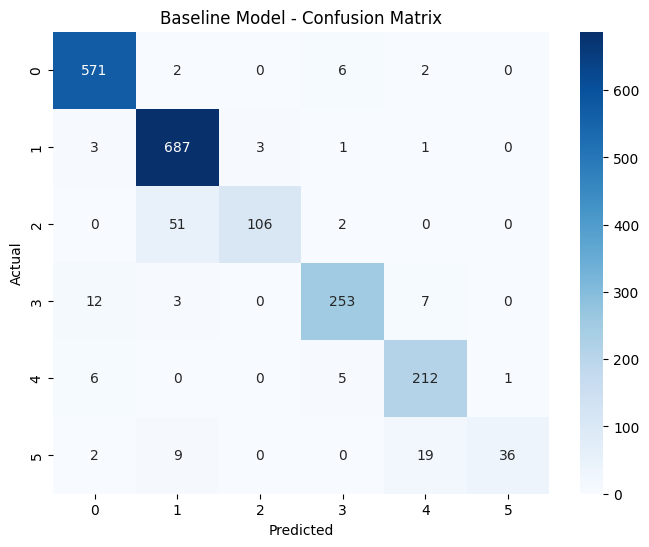

Baseline Model - Test Accuracy: 0.9325
Total Inference Time: 13.04 seconds
Average Time per Sample: 0.0065 seconds
Macro F1 Score: 0.8762


In [ ]:
from sklearn.metrics import f1_score
from time import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Load the saved baseline model
model_baseline_loaded = AutoModelForSequenceClassification.from_pretrained("repo/saved/baseline-model")
model_baseline_loaded.to(device)
model_baseline_loaded.eval()

# Perform inference and measure time
start_time = time()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running baseline inference"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model_baseline_loaded(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time()
inference_time = end_time - start_time

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Model - Confusion Matrix')
plt.show()


accuracy = correct / total
macro_f1 = f1_score(all_labels, all_predictions, average='macro')

print(f"Baseline Model - Test Accuracy: {accuracy:.4f}")
print(f"Total Inference Time: {inference_time:.2f} seconds")
print(f"Average Time per Sample: {inference_time/total:.4f} seconds")
print(f"Macro F1 Score: {macro_f1:.4f}")

Running PTQ inference:   0%|          | 0/250 [00:00<?, ?it/s]

Running PTQ inference: 100%|██████████| 250/250 [07:30<00:00,  1.80s/it]


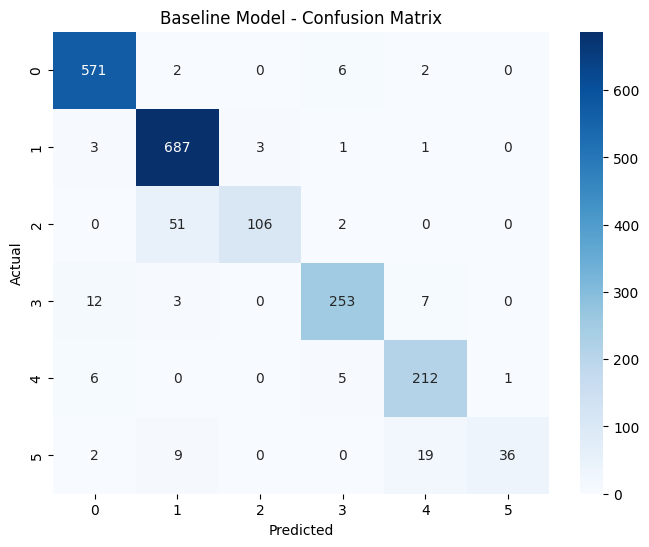

PTQ Model - Test Accuracy: 0.9325
Total Inference Time: 450.13 seconds
Average Time per Sample: 0.2251 seconds
Macro F1 Score: 0.8762


In [ ]:
from peft import PeftModel

# Load baseline model on CPU for quantization
model_baseline_cpu = AutoModelForSequenceClassification.from_pretrained("reposaved/baseline-model")
model_baseline_cpu.to("cpu")

model_baseline_cpu.eval()

start_time = time()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running PTQ inference"):
        input_ids = batch["input_ids"].cpu()
        attention_mask = batch["attention_mask"].cpu()
        labels = batch["labels"].cpu()
        
        outputs = model_baseline_cpu(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time()
inference_time = end_time - start_time

accuracy = correct / total
macro_f1 = f1_score(all_labels, all_predictions, average='macro')

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Model - Confusion Matrix')
plt.show()


print(f"PTQ Model - Test Accuracy: {accuracy:.4f}")
print(f"Total Inference Time: {inference_time:.2f} seconds")
print(f"Average Time per Sample: {inference_time/total:.4f} seconds")
print(f"Macro F1 Score: {macro_f1:.4f}")


Running QAT inference:   2%|▏         | 4/250 [00:00<00:12, 19.46it/s]

Running QAT inference: 100%|██████████| 250/250 [00:12<00:00, 19.56it/s]


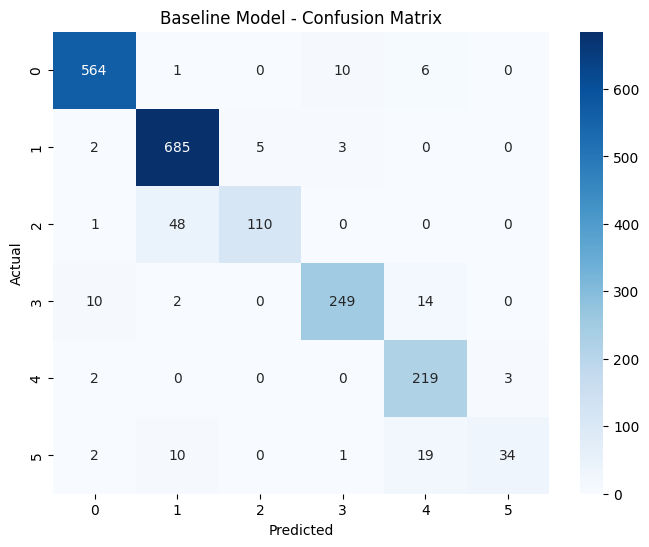

QAT Model - Test Accuracy: 0.9305
Total Inference Time: 12.78 seconds
Average Time per Sample: 0.0064 seconds
Macro F1 Score: 0.8698


In [ ]:

# QAT Model Evaluation
model_qat_loaded = AutoModelForSequenceClassification.from_pretrained("repo/saved/qat_bert_int8")
model_qat_loaded.to(device)
model_qat_loaded.eval()

start_time = time()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running QAT inference"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model_qat_loaded(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time()
inference_time = end_time - start_time

accuracy = correct / total
macro_f1 = f1_score(all_labels, all_predictions, average='macro')

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Model - Confusion Matrix')
plt.show()


print(f"QAT Model - Test Accuracy: {accuracy:.4f}")
print(f"Total Inference Time: {inference_time:.2f} seconds")
print(f"Average Time per Sample: {inference_time/total:.4f} seconds")
print(f"Macro F1 Score: {macro_f1:.4f}")



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-11-20 13:46:47 [WARNING][auto_accelerator.py:454] Auto detect accelerator: CUDA_Accelerator.
2025-11-20 13:46:47 [WARNING][auto_accelerator.py:454] Auto detect accelerator: CUDA_Accelerator.
2025-11-20 13:46:47 [WARNING][fp_utils.py:127] hw aligned scales not supported for device INCAcceleratorType.CUDA
Running Q-LoRA inference: 100%|██████████| 250/250 [00:13<00:00, 18.49it/s]


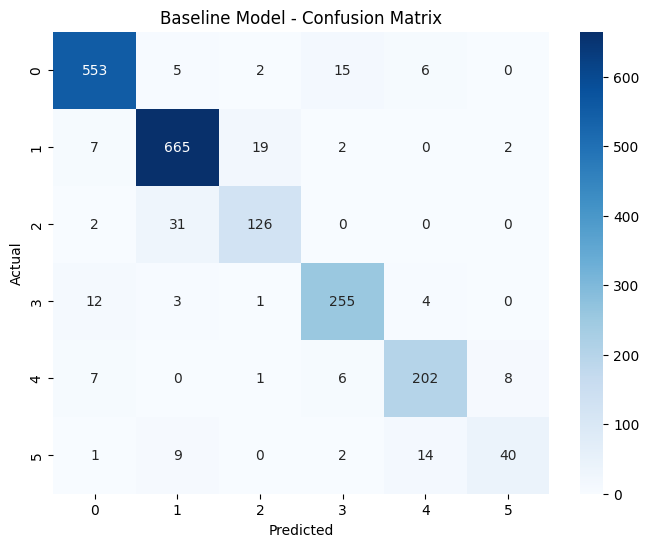

Q-LoRA Model - Test Accuracy: 0.9205
Total Inference Time: 13.52 seconds
Average Time per Sample: 0.0068 seconds
Macro F1 Score: 0.8700


In [ ]:
# Q-LoRA Model Evaluation

model_qlora_loaded = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=6)
model_qlora_loaded = PeftModel.from_pretrained(model_qlora_loaded, "repo/saved/qlora-bert-adapter")
model_qlora_loaded.to(device)
model_qlora_loaded.eval()

start_time = time()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running Q-LoRA inference"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model_qlora_loaded(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time()
inference_time = end_time - start_time

accuracy = correct / total
macro_f1 = f1_score(all_labels, all_predictions, average='macro')

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Model - Confusion Matrix')
plt.show()


print(f"Q-LoRA Model - Test Accuracy: {accuracy:.4f}")
print(f"Total Inference Time: {inference_time:.2f} seconds")
print(f"Average Time per Sample: {inference_time/total:.4f} seconds")
print(f"Macro F1 Score: {macro_f1:.4f}")